Realizar un estudio de aprendizaje supervisado utilizando árboles de decisión, tanto para clasificación como para regresión. Para ello en esta tarea se usarán 4 datasets (los tres de la práctica anterior y uno que introduce series temporales).

**Ejercicio 4.** https://www.kaggle.com/marklvl/bike-sharing-dataset. Predicción de números de bicicletas alquiladas por cada hora. El dataset contiene una serie de datos como temperatura, humedad, si es día laborable, etc. El objetivo es predecir cuantas bicicletas se van a alquilar dependiendo de esa serie de parámetros.

**_Importación de librerías necesarias_**

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from typing import Tuple
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO
import joblib
import matplotlib.pyplot as plt

**_Preproceso_**

*Importación de los datos del dataset*

In [46]:
drive.mount("/content/drive")

df_hour = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/hour.csv")
df_day = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/day.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Mostrar las primera y últimas filas del data frame importado*

In [47]:
df_hour
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no se jupiter se haría de la siguiente forma:
# df_hour.head()
# df_hour.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [48]:
df_day
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no se jupiter se haría de la siguiente forma:
# df_day.head()
# df_day.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Fusiono ambos datasets mediante la fecha.

In [49]:
df_bike = df_hour.merge(df_day, on="dteday", suffixes=("_hour", "_day"))

Muestro las primeras líneas del nuevo dataframe.

In [50]:
df_bike
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no se jupiter se haría de la siguiente forma:
# df_bike.head()
# df_bike.tail()

,instant_hour,dteday,season_hour,yr_hour,mnth_hour,hr,holiday_hour,weekday_hour,workingday_hour,weathersit_hour,...,weekday_day,workingday_day,weathersit_day,temp_day,atemp_day,hum_day,windspeed_day,casual_day,registered_day,cnt_day
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


*Mostar parámetros estadísticos de los datos (media, desviación típica, quartiles, etc.).*

In [51]:
df_bike.describe()

,instant_hour,season_hour,yr_hour,mnth_hour,hr,holiday_hour,weekday_hour,workingday_hour,weathersit_hour,temp_hour,...,weekday_day,workingday_day,weathersit_day,temp_day,atemp_day,hum_day,windspeed_day,casual_day,registered_day,cnt_day
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,...,3.003683,0.682721,1.391680,0.496987,0.475775,0.627229,0.190098,854.339720,3679.353242,4533.692963
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,...,2.005771,0.465431,0.540501,0.182445,0.162426,0.141779,0.077204,685.686754,1544.953518,1917.376947
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,...,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,...,1.000000,0.000000,1.000000,0.340000,0.338363,0.520000,0.134950,318.000000,2545.000000,3214.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,...,3.000000,1.000000,1.000000,0.502500,0.490122,0.625833,0.180967,724.000000,3681.000000,4563.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,...,5.000000,1.000000,2.000000,0.655833,0.610488,0.729583,0.233204,1100.000000,4801.000000,5986.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,...,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


*Mostrar un mapa de calor que indique la correlación entre variables*

<Axes: >

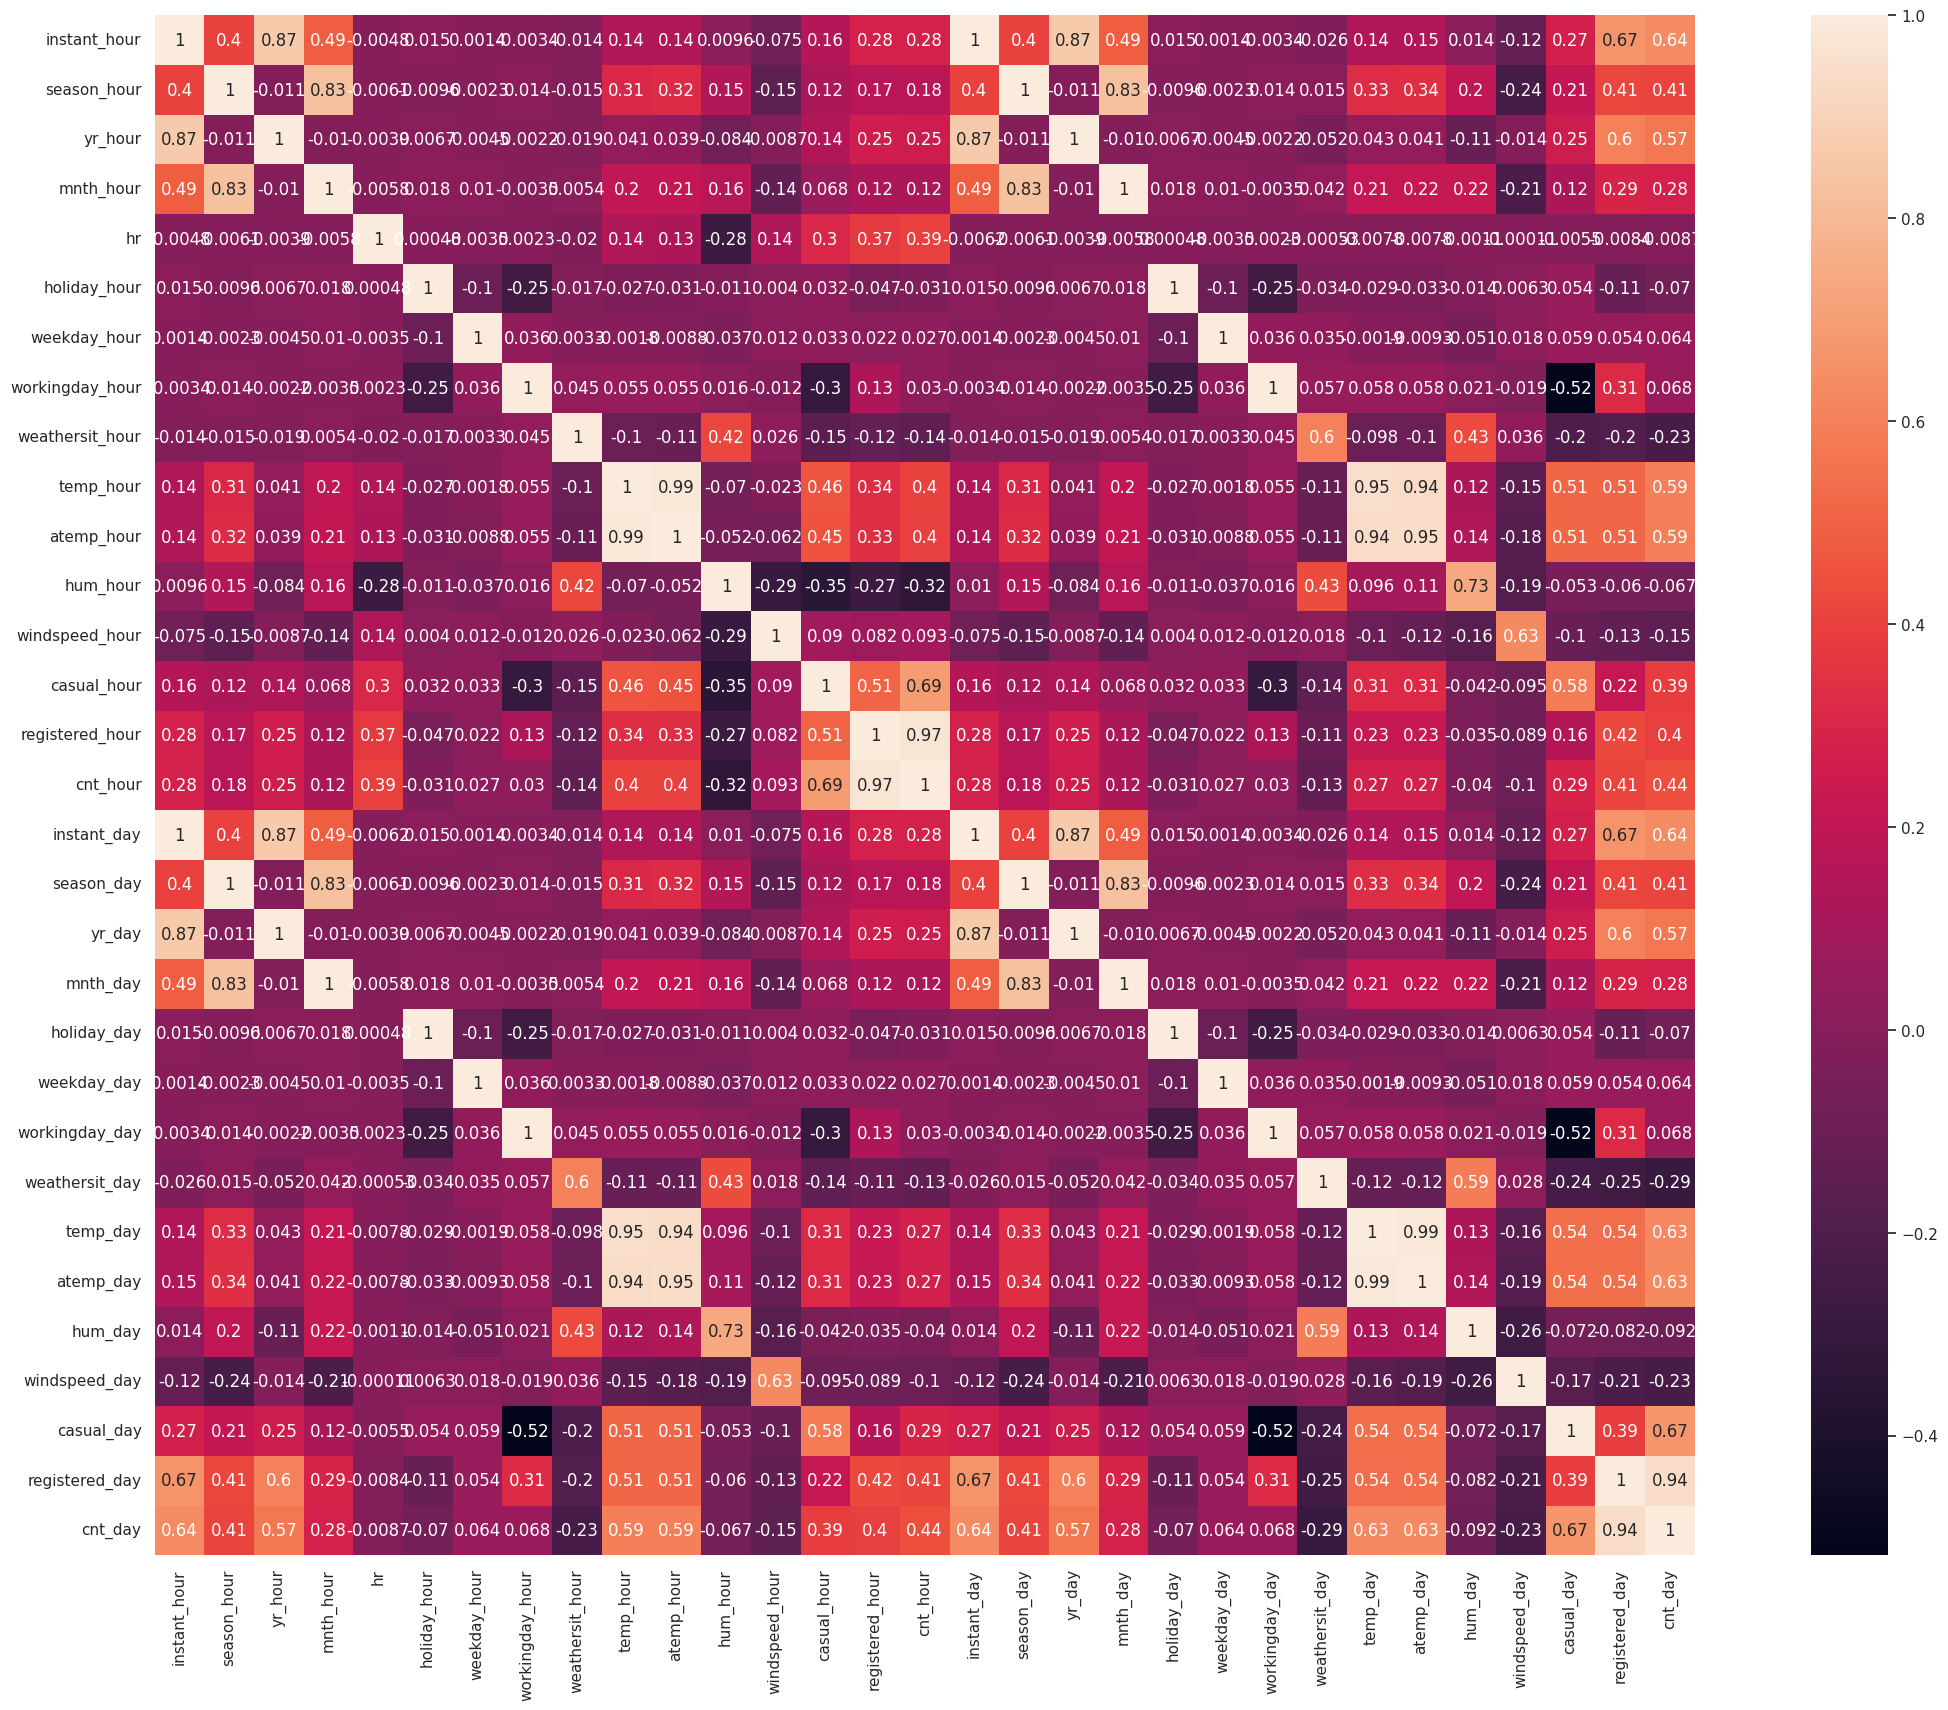

In [52]:
sns.set(rc={"figure.figsize": (30, 20)})
sns.heatmap(df_bike.drop("dteday", axis=1).corr(), square = True, annot = True)

Como se puede observar en el ejemplo anterior del mapa de calor, existen demasiados atributos. Para ello voy a filtrar las relaciones que tengan más de un 0.3.

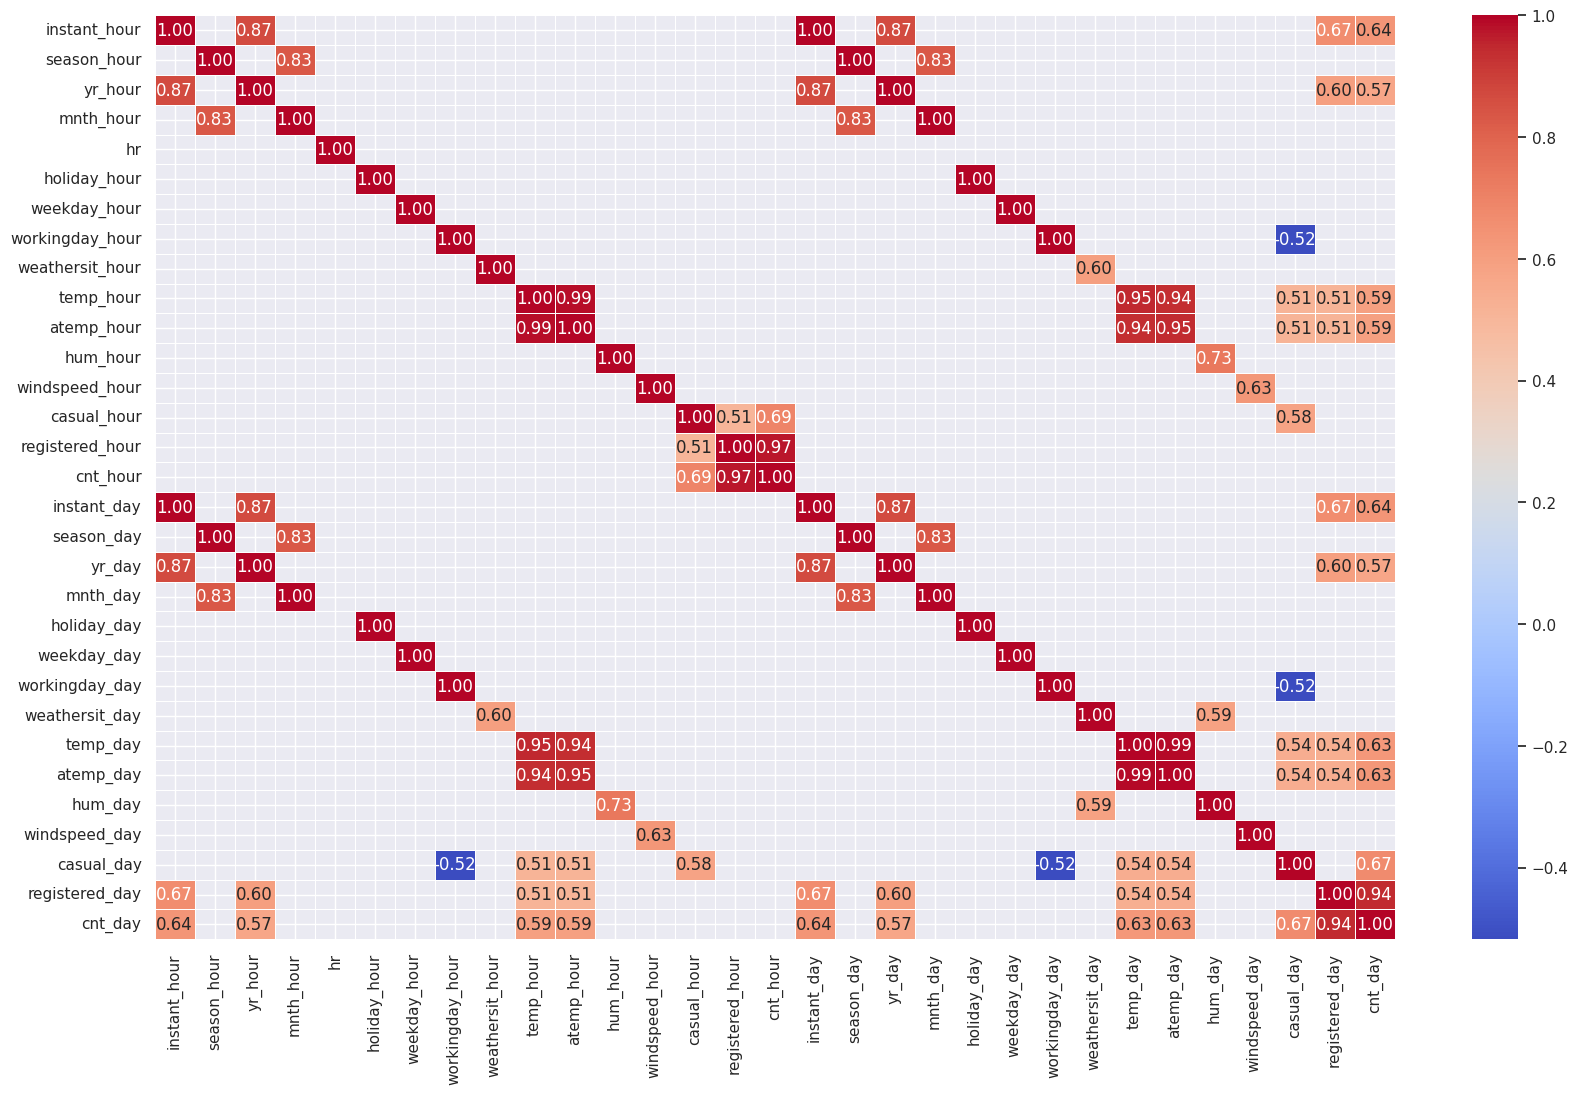

In [53]:
filtered_corr = df_bike.drop("dteday", axis=1).corr()
filtered_corr[abs(filtered_corr) < 0.5] = np.nan
plt.figure(figsize=(20, 12))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask=np.isnan(filtered_corr))
plt.show()

*Separar datos entre datos de entrada y etiquetas (resultados)*

In [54]:
# Se han escogido ambos atributos (atemp_day, temp_day, atemp_hour, temp_hour) aunque atemp_day debería de ser más importante porque para alquilar una bicicleta tiene más importancia la sensación térmica.
# También realizaré pruebas para comprobar si cambia mucho la probalidad del modelo elimando los siguientes atributos: yr_day, yr_hour, instant_day, instant_hour porque me he dado cuenta que tienen el mismo valor en el mapa de calor
x_df_bike = df_bike[["registered_day", "casual_day", "atemp_day", "temp_day", "yr_day", "instant_day", "atemp_hour", "temp_hour", "yr_hour", "instant_hour"]]

y_df_bike = df_bike['cnt_day']

*Separar datos entre entrenamiento y prueba (usando un 80% para entrenamiento y 20% test)*

In [55]:
x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_bike, y_df_bike, random_state=1, test_size=0.2)

**_Entrenamiento y predicción_**

_Elegir, instanciar (eligiendo unos valores concretos, por ejemplo profundidad del árbol 3) y entrenar modelo_

In [56]:
modelo = DecisionTreeRegressor(max_depth=3)
modelo.fit(x_entrenamiento, y_entrenamiento)

DecisionTreeRegressor(max_depth=3)

*Realizar una predicción con los datos de prueba*

In [57]:
y_prediccion = modelo.predict(x_test)

_Mostrar el árbol de decisión resultante_

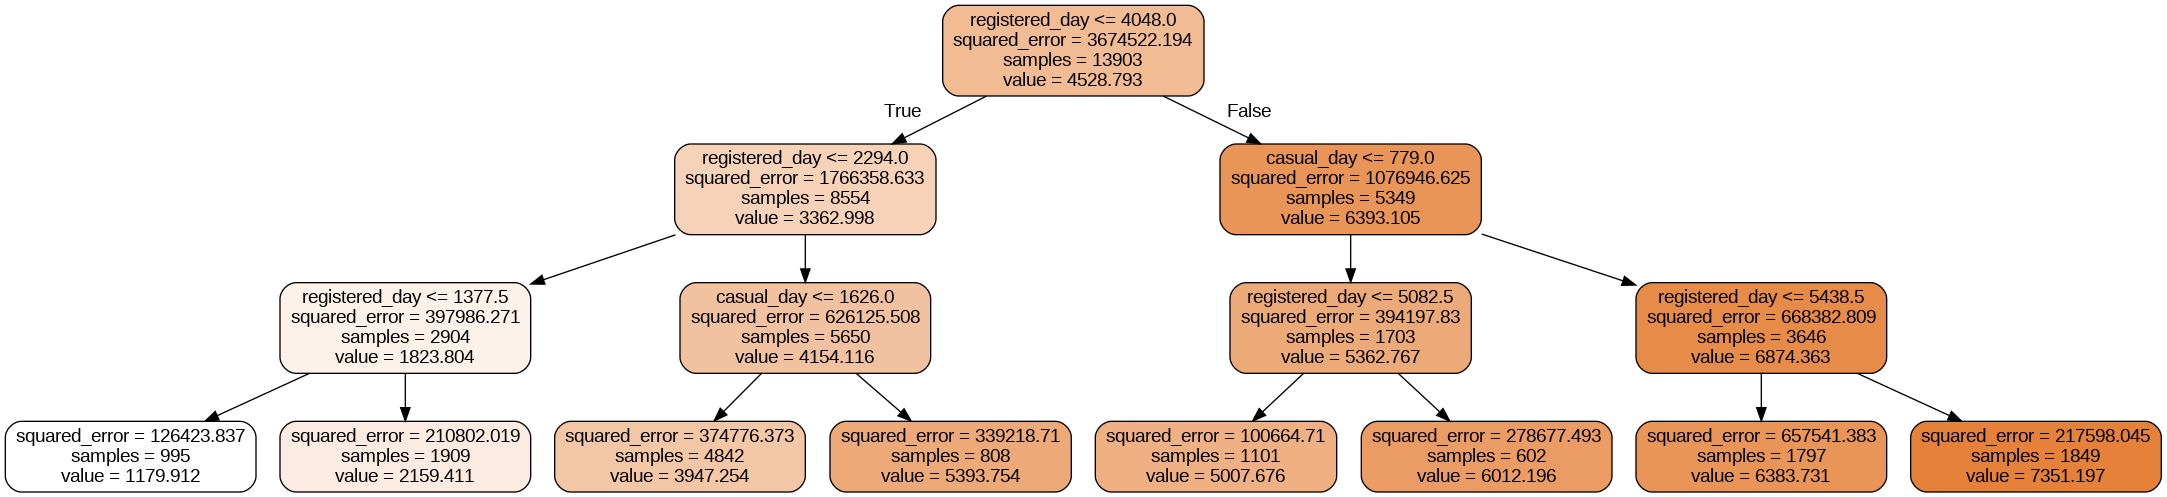

In [58]:
dot_data = StringIO()

tree.export_graphviz(modelo, out_file=dot_data, feature_names=x_entrenamiento.columns, rounded=True, filled=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

_Mostrar la importancia de cada atributo en el arbol resultante_

In [59]:
caracteristicas = ["registered_day", "casual_day", "atemp_day", "temp_day", "yr_day", "instant_day", "atemp_hour", "temp_hour", "yr_hour", "instant_hour"]
for caracteristica, importancia in zip(caracteristicas, modelo.feature_importances_):
  print(f"{caracteristica}: {importancia:.3f}")

registered_day: 0.912
casual_day: 0.088
atemp_day: 0.000
temp_day: 0.000
yr_day: 0.000
instant_day: 0.000
atemp_hour: 0.000
temp_hour: 0.000
yr_hour: 0.000
instant_hour: 0.000


_Intenta guardar el modelo de predicción ya entrenado usando dump (https://scikit-learn.org/stable/modules/model_persistence.html)_

In [60]:
# Guardo el modelo. Se guarda el fichero en colab en el directorio /content.
joblib.dump(modelo, "df_bike_modelo_entrenado.joblib")

['df_bike_modelo_entrenado.joblib']

**_Evaluación_**

*Mostrar el error cuadrático medio (mean_squared_error)*

In [61]:
print("El error cuadrático medio:", mean_squared_error(y_test, y_prediccion))

El error cuadrático medio: 319204.55756664043


*Mostrar el error absoluto medio (mean_absolute_error)*

In [62]:
print("El error absoluto medio:", mean_absolute_error(y_test, y_prediccion))

El error absoluto medio: 443.7153972470815


*Representar gráficamente los valores predichos con los valores reales.*

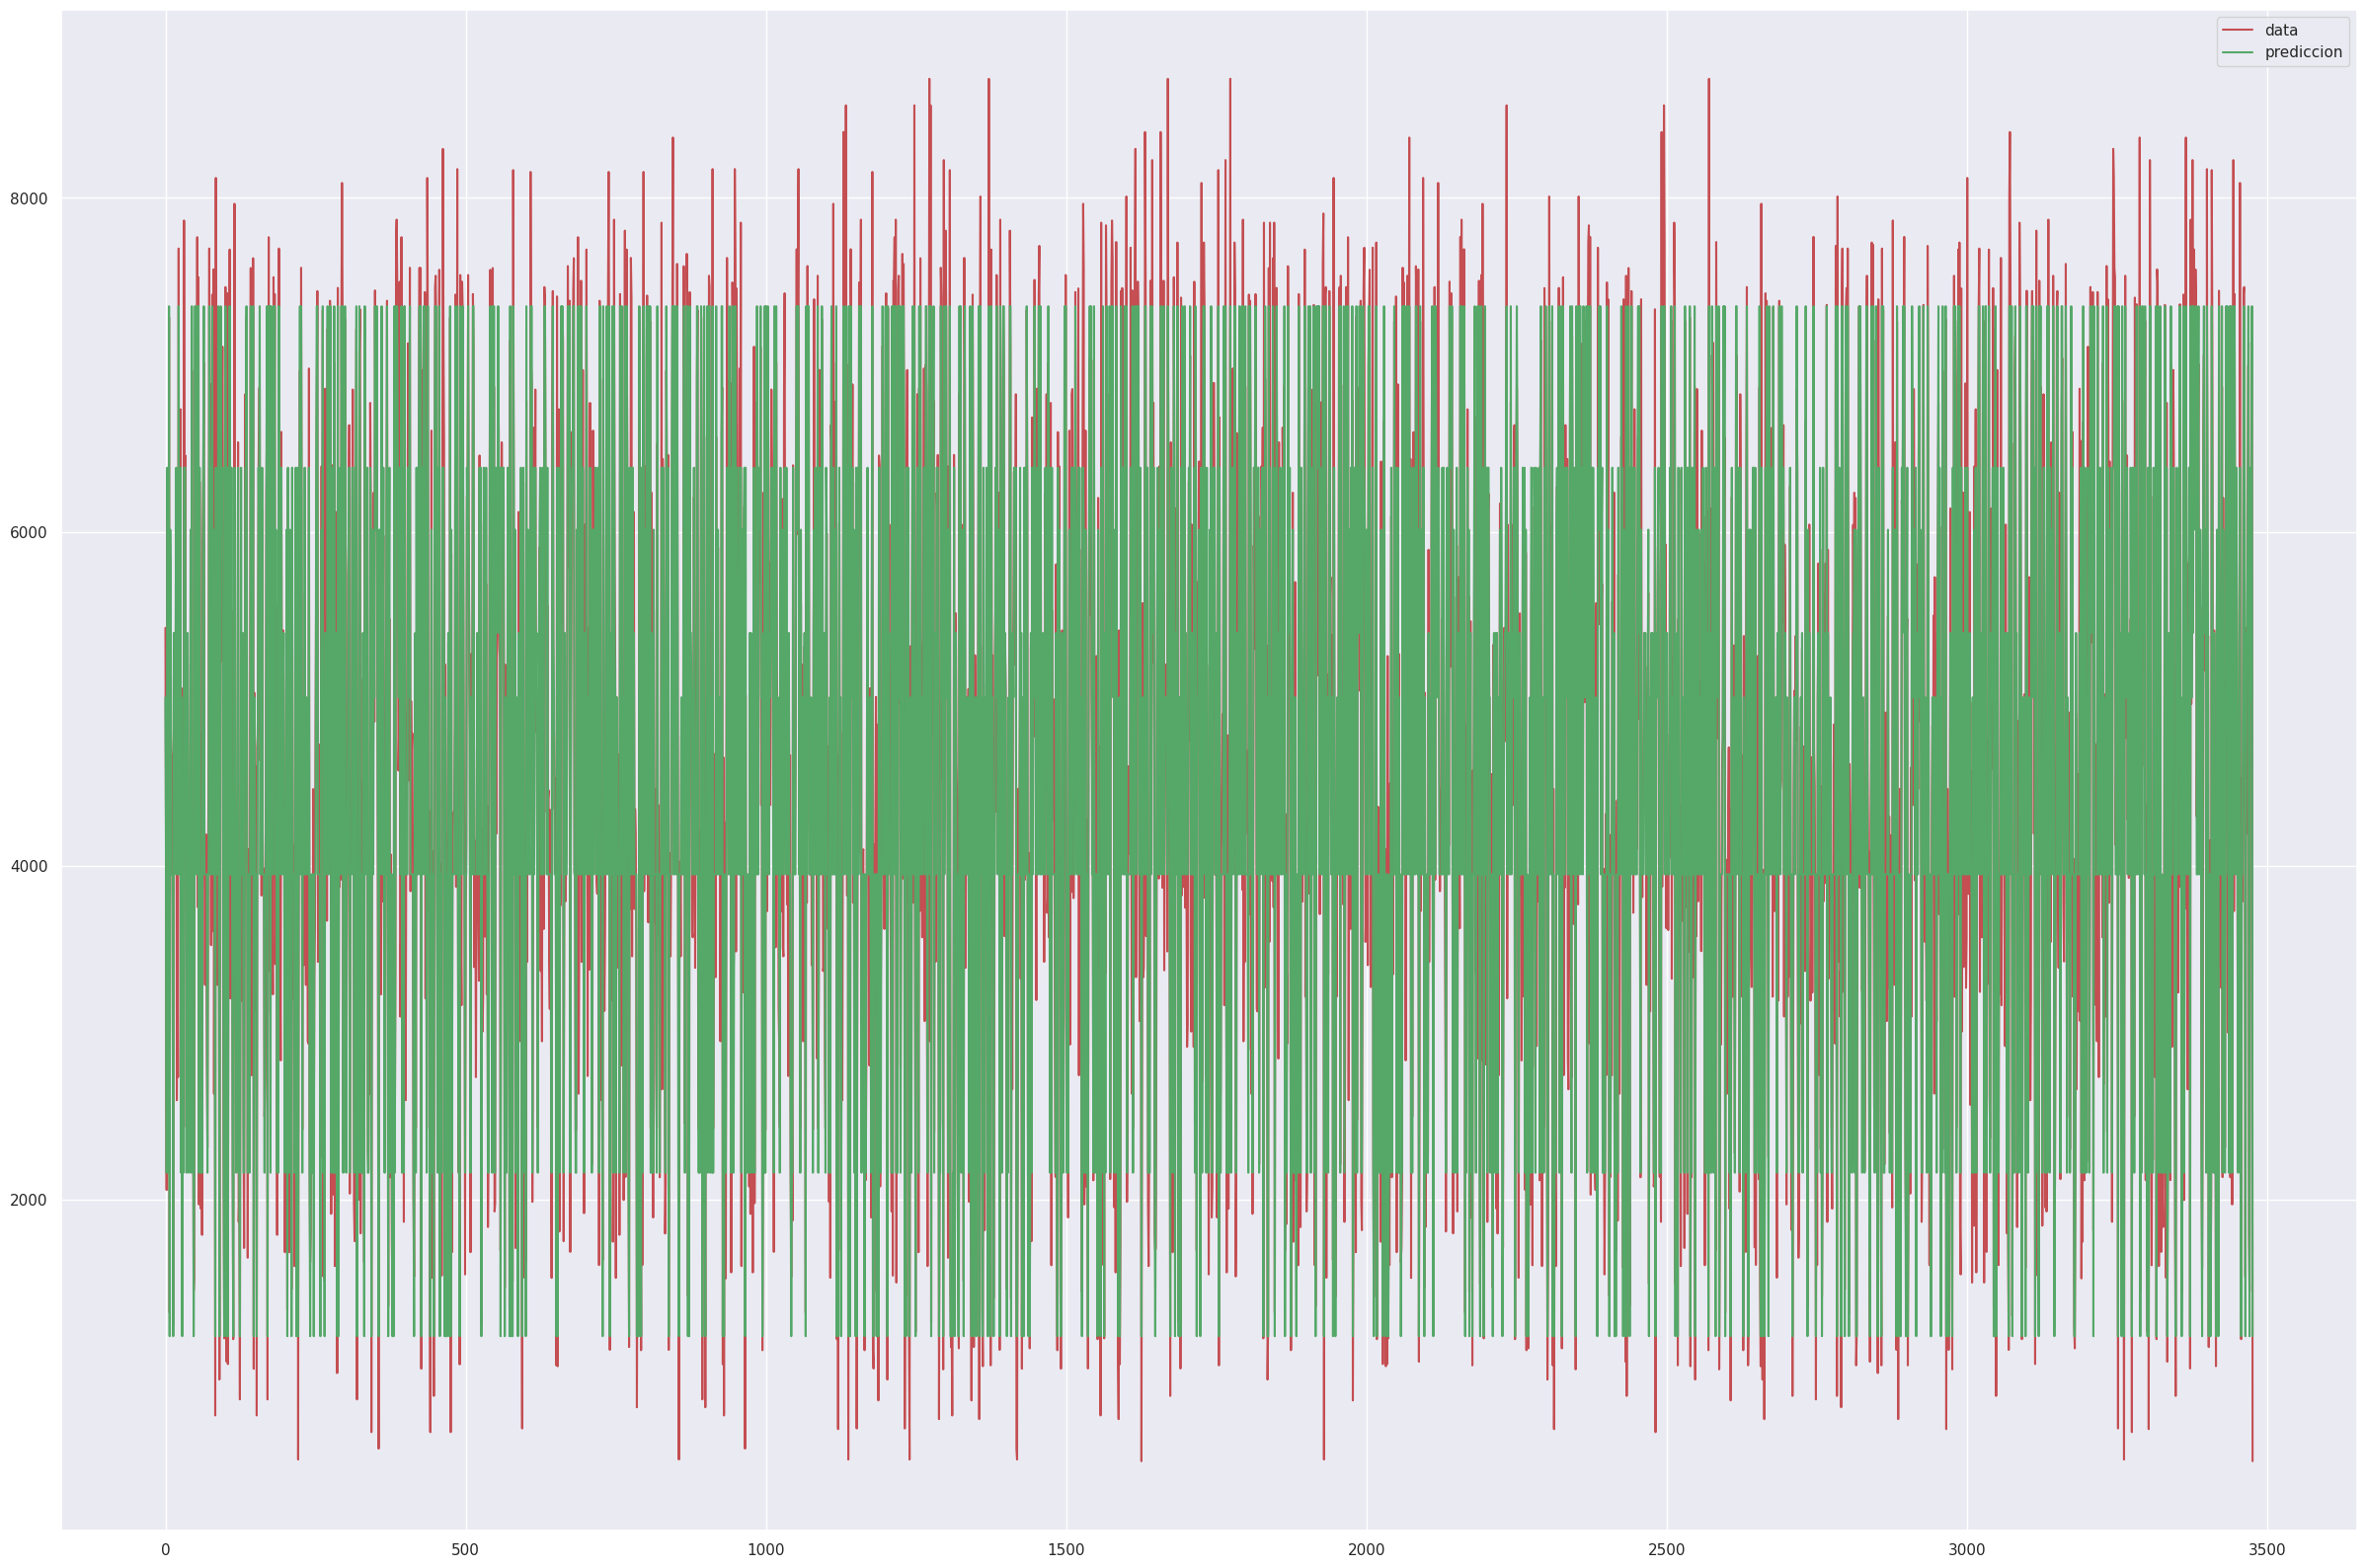

In [63]:
xx = np.stack([i for i in range(y_test.shape[0])])
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_prediccion, c='g', label='prediccion')
plt.axis('tight')
plt.legend()
plt.show()

**_Optimización de hiperparámetros_**

En este apartado he eliminado todos los atributos cuya importancia sea 0.00. Los atributos con los que se ha quedado ha sido registered_day y casual_day.

_Calcula la combinación de parámetros óptima (profundidad de árbol y criterio). Para ello realiza ejecuciones con cada uno de los valores del criterio para los valores de profundidad de árbol de 1 a 15._

In [64]:
x_df_bike = df_bike[["registered_day", "casual_day"]]

y_df_bike = df_bike['cnt_day']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "error_cuadratico_medio", "error_absoluto_medio"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_bike, y_df_bike, random_state=1, test_size=0.2)

for i in range(1, 16):
  modelo = DecisionTreeRegressor(max_depth=i)
  modelo.fit(x_entrenamiento, y_entrenamiento)

  y_prediccion = modelo.predict(x_test)

  df_opt.loc[len(df_opt)] = [i, mean_squared_error(y_test, y_prediccion), mean_absolute_error(y_test, y_prediccion)]


df_opt

,max_depth,error_cuadratico_medio,error_absoluto_medio
0,1.0,1.521806e+06,1040.424805
1,2.0,5.760455e+05,601.236980
2,3.0,3.192046e+05,443.715397
3,4.0,1.634869e+05,323.880915
4,5.0,6.698266e+04,195.652989
5,6.0,3.034982e+04,132.851700
6,7.0,1.196613e+04,79.213993
7,8.0,4.882237e+03,47.114195
8,9.0,1.796098e+03,25.755958
9,10.0,5.721386e+02,12.885680


_Cada ejecución anterior se deberá hacer usando validación cruzada (por ejemplo n_splits = 5). Con ello obtendremos una medida de bondad del modelo (accuaracy_score o mean_absolute_error), como lo ejecutaremos 5 veces, calcularemos la media de esas 5 ejecuciones._

In [65]:
x_df_bike = df_bike[["registered_day", "casual_day"]]

y_df_bike = df_bike['cnt_day']

df_opt = pd.DataFrame(data={}, columns=["max_depth", "error_cuadratico_medio", "error_absoluto_medio"])

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_bike, y_df_bike, random_state=1, test_size=0.2)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, 16):
  modelo = DecisionTreeRegressor(max_depth=i)
  puntuaciones_mae = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring=make_scorer(mean_absolute_error))
  puntuaciones_mse = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring=make_scorer(mean_squared_error))

  media_mae = np.mean(puntuaciones_mae)
  media_mse = np.mean(puntuaciones_mse)

  df_opt.loc[len(df_opt)] = [i, media_mse, media_mae]

df_opt

,max_depth,error_cuadratico_medio,error_absoluto_medio
0,1.0,1.505376e+06,1041.594139
1,2.0,5.767808e+05,598.595812
2,3.0,3.014089e+05,436.967558
3,4.0,1.547030e+05,309.219023
4,5.0,6.876120e+04,201.978186
5,6.0,3.228705e+04,136.140138
6,7.0,1.322140e+04,83.969536
7,8.0,5.218196e+03,48.770988
8,9.0,1.972838e+03,27.456270
9,10.0,7.024951e+02,14.056976


_Finalmente los parámetros elegidos serán los que den mejor media de esas medidas anteriormente nombradas._

Si observamos los errores_medios de ambos, se puede observar que hasta el paso 12 se nota una mejoría notable, pero a partir de este puede ser que modelo se esté sobreajustando a sobreentrenando.

_Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostramos los resultados._

In [66]:
x_df_bike = df_bike[["registered_day", "casual_day"]]

y_df_bike = df_bike['cnt_day']

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_bike, y_df_bike, random_state=1, test_size=0.2)

modelo = DecisionTreeRegressor(max_depth=12)
modelo.fit(x_entrenamiento, y_entrenamiento)

y_prediccion = modelo.predict(x_test)


print("El error cuadrático medio:", mean_squared_error(y_test, y_prediccion))
print("El error absoluto medio:", mean_absolute_error(y_test, y_prediccion))

El error cuadrático medio: 32.44740182307504
El error absoluto medio: 1.6436819551551578


Aquí se puede observar la diferencia tan grande que hay entre poner el parámetro "max_depth" en 12, en vez de 2. La media de ambos errores ha disminuido notablemente. Al poner el argumento a 3, el modelo no ha podido ajustarse lo necesario mientras que con 15 puede ser que se esté ajustando demasiado ya que la mejoría no es tan notable.